In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant
from scipy.stats.mstats import winsorize

In [2]:
def combine_md_datetime(df, date_col='MDDate', time_col='MDTime', new_col='DateTime',drop_original=True):
    """
    日期和时间合并为标准datetime
    """
    df[date_col] = df[date_col].astype(str)
    df[time_col] = df[time_col].astype(str).str.zfill(9)
    datetime_str = df[date_col] + ' ' + df[time_col].str[:6]
    df[new_col] = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    
    if drop_original:
        df.drop(columns=[date_col, time_col], inplace=True)
    return df

In [3]:
# 数据
etf = pd.read_csv("../data/518880.SH_20250101_20250630.csv",usecols=['MDDate','MDTime','LastPx','Buy1Price','Sell1Price'])
au = pd.read_csv("../data/AU99.99.SGE_20250101_20250630.csv",usecols=['MDDate','MDTime', 'LastPx','Buy1Price','Sell1Price'])

#清洗
#区分价格
etf.rename(columns={'LastPx': 'ETF_Price','Buy1Price':'ETF_Buy1Price','Sell1Price':'ETF_Sell1Price'}, inplace=True)
au.rename(columns={'LastPx': 'AU_Price','Buy1Price':'AU_Buy1Price','Sell1Price':'AU_Sell1Price'}, inplace=True)

#删去0值
etf = etf[etf['ETF_Price'] != 0]
au = au[au['AU_Price'] != 0]

#时间规范
etf = combine_md_datetime(etf)
au = combine_md_datetime(au)

#对齐
merged = pd.merge_asof(etf,au,on='DateTime',direction='backward')


In [4]:
#cointegrated检验
def check_cointegration(df, etf_col='ETF_Price', au_col='AU_Price', time_col='ReceiveDateTime', freq='10S'):
    """
    ETF和黄金现货价格进行协整检验 每10秒采样的精度
    """
    df = df[[time_col, etf_col, au_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df.set_index(time_col, inplace=True)

    # 采样
    df_resampled = df.resample(freq).last().dropna()

    # 变量
    x = df_resampled[etf_col]
    y = df_resampled[au_col]

    # 检验
    score, pvalue, _ = coint(x, y)

    # 输出
    if pvalue < 0.05:
        print(pvalue)
    else:
        print("不显著")

    return pvalue

/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2331640755.py:18: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2331640755.py:18: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2331640755.py:18: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2331640755.py:18: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2331640755.py:18: UserWarning: Glyph 27531 (\N{CJK UNIFIED IDEOGRAPH-6B8B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2

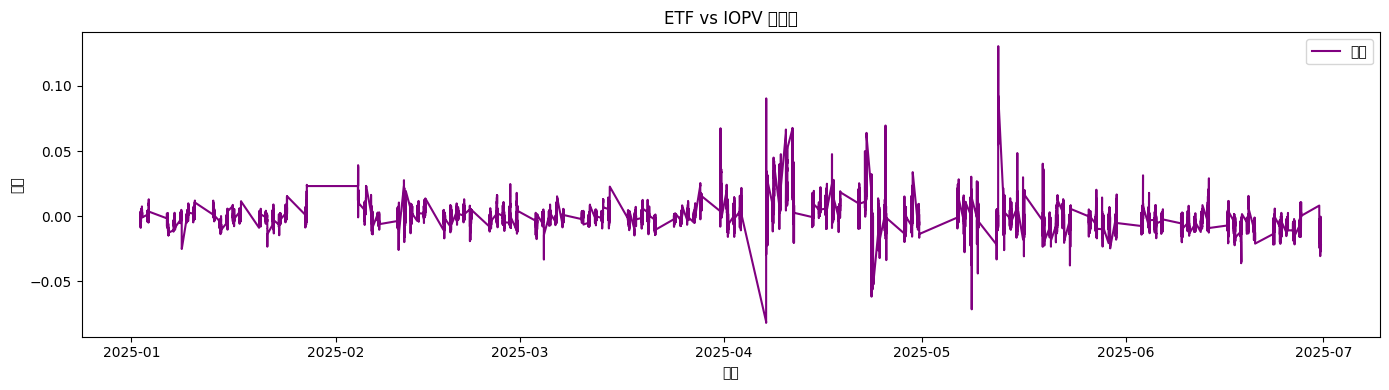

In [5]:
#IOPV估值
gold_per_unit_etf = 0.01
merged['IOPV_estimated'] = merged['AU_Price'] * gold_per_unit_etf
#回归
X = add_constant(merged['IOPV_estimated'])
y = merged['ETF_Price']
model = OLS(y, X).fit()
merged['fitted'] = model.predict(X)
#残差
merged['residual'] = merged['ETF_Price'] - merged['fitted']
#残差图
plt.figure(figsize=(14, 4))
plt.plot(merged['DateTime'], merged['residual'], color='purple', label='残差')
plt.title('ETF vs IOPV 残差图')
plt.xlabel('时间')
plt.ylabel('差值')
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/2027152561.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/guziyi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


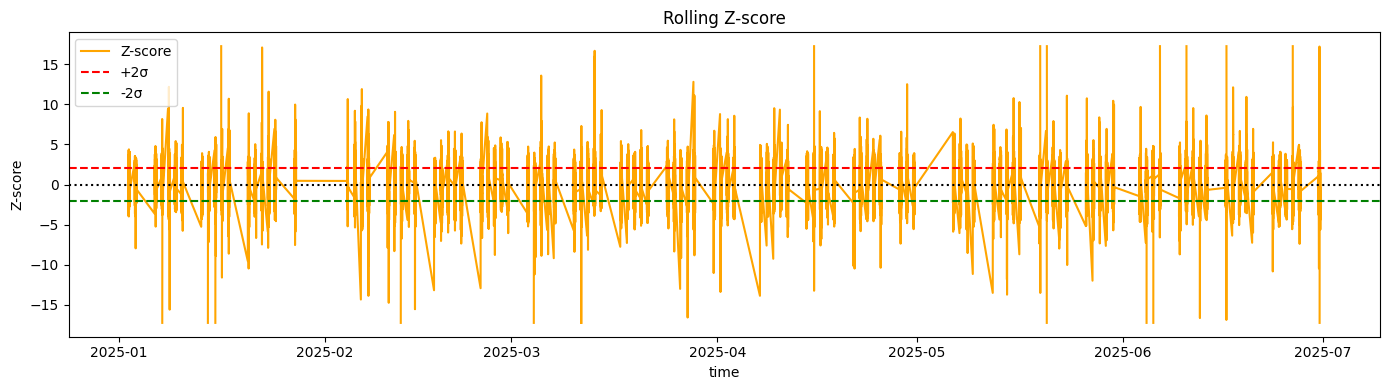

In [6]:
#滚动Z-score
window = 300
merged['res_mean'] = merged['residual'].rolling(window=window).mean()
merged['res_std'] = merged['residual'].rolling(window=window).std()
merged['zscore'] = (merged['residual'] - merged['res_mean']) / merged['res_std']
#Z-score图
plt.figure(figsize=(14, 4))
plt.plot(merged['DateTime'], merged['zscore'], color='orange', label='Z-score')
plt.axhline(2, color='red', linestyle='--', label='+2σ')
plt.axhline(-2, color='green', linestyle='--', label='-2σ')
plt.axhline(0, color='black', linestyle=':')
plt.title('Rolling Z-score')
plt.xlabel('time')
plt.ylabel('Z-score')
plt.legend()
plt.tight_layout()
plt.show()

第一份交易代码

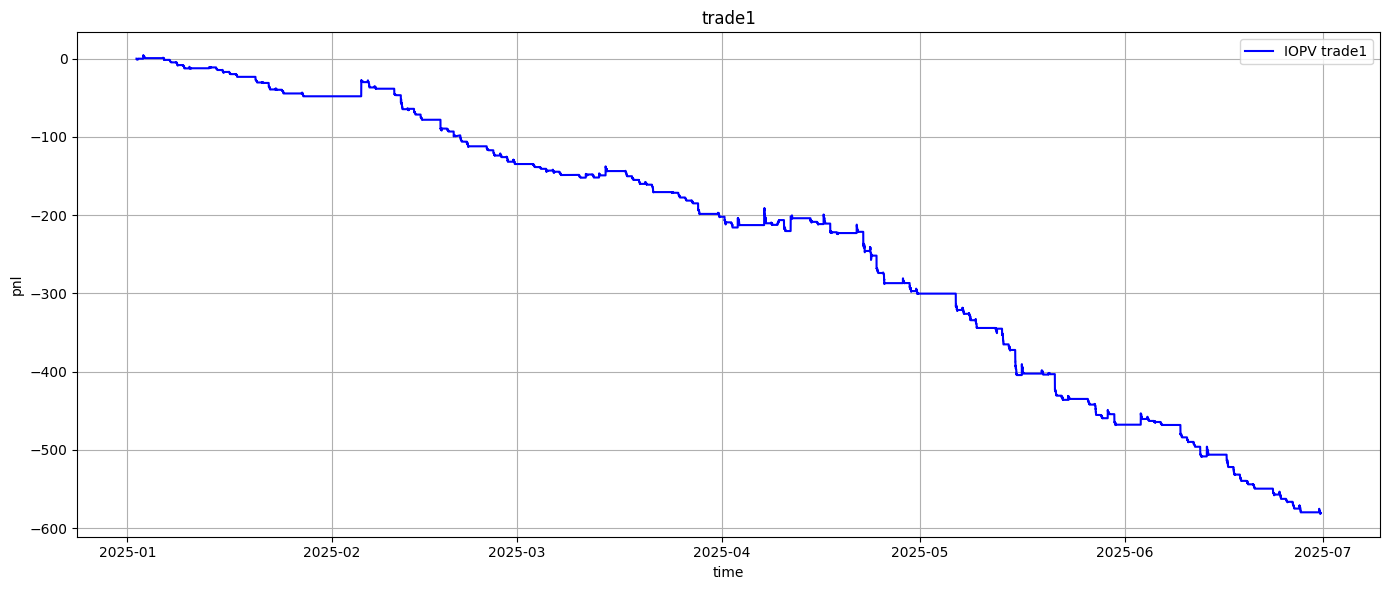

In [7]:
#初始
position = 0
entry_threshold = 2.0
exit_threshold = 0.1
etf_fee_rate = 0.0006  # ETF 双边万三手续费

entry_price_etf = 0
entry_price_au = 0

pnl_list = []
position_list = []

last_z = 0  # 上一tick的z-score，用于平仓判断

# 遍历每一tick
for i in range(len(merged)):
    row = merged.iloc[i]
    z = row['zscore']

    etf_buy = row['ETF_Sell1Price']      # 买入ETF（吃 ask）
    etf_sell = row['ETF_Buy1Price']      # 卖出ETF（吃 bid）
    au_buy = row['AU_Sell1Price']
    au_sell = row['AU_Buy1Price']

    pnl = 0
    
    if position == 0:
        if z > entry_threshold:
            # 做空ETF买入现货
            position = -1
            entry_price_etf = etf_sell
            entry_price_au = au_buy
        elif z < -entry_threshold:
            # 做多ETF卖出现货
            position = 1
            entry_price_etf = etf_buy
            entry_price_au = au_sell
        pnl_list.append(0)
        position_list.append(position)
        
    elif position == 1:
        if abs(z) < exit_threshold:
            # 平多头：卖出ETF买入现货
            exit_etf = etf_sell
            exit_au = au_buy
            gross_pnl = (exit_etf - entry_price_etf) - (exit_au - entry_price_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)
        
    elif position == -1:
        if abs(z) < exit_threshold:
            # 平空头：买入ETF卖出现货
            exit_etf = etf_buy
            exit_au = au_sell
            gross_pnl = (entry_price_etf - exit_etf) - (entry_price_au - exit_au)
            etf_cost = (entry_price_etf + exit_etf) * etf_fee_rate
            pnl = gross_pnl - etf_cost
            position = 0
        pnl_list.append(pnl)
        position_list.append(position)
        
# 记录
merged['position'] = position_list
merged['pnl'] = pnl_list
merged['cum_pnl'] = merged['pnl'].cumsum()
#画个图
plt.figure(figsize=(14, 6))
plt.plot(merged['DateTime'], merged['cum_pnl'], label='IOPV trade1', color='blue')
plt.title("trade1")
plt.xlabel("time")
plt.ylabel("pnl")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/786411212.py:20: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/786411212.py:20: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/786411212.py:20: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/786411212.py:20: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53myncg5mkghpm0000gn/T/ipykernel_9692/786411212.py:20: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/l7/tn6pwj1d2r53my

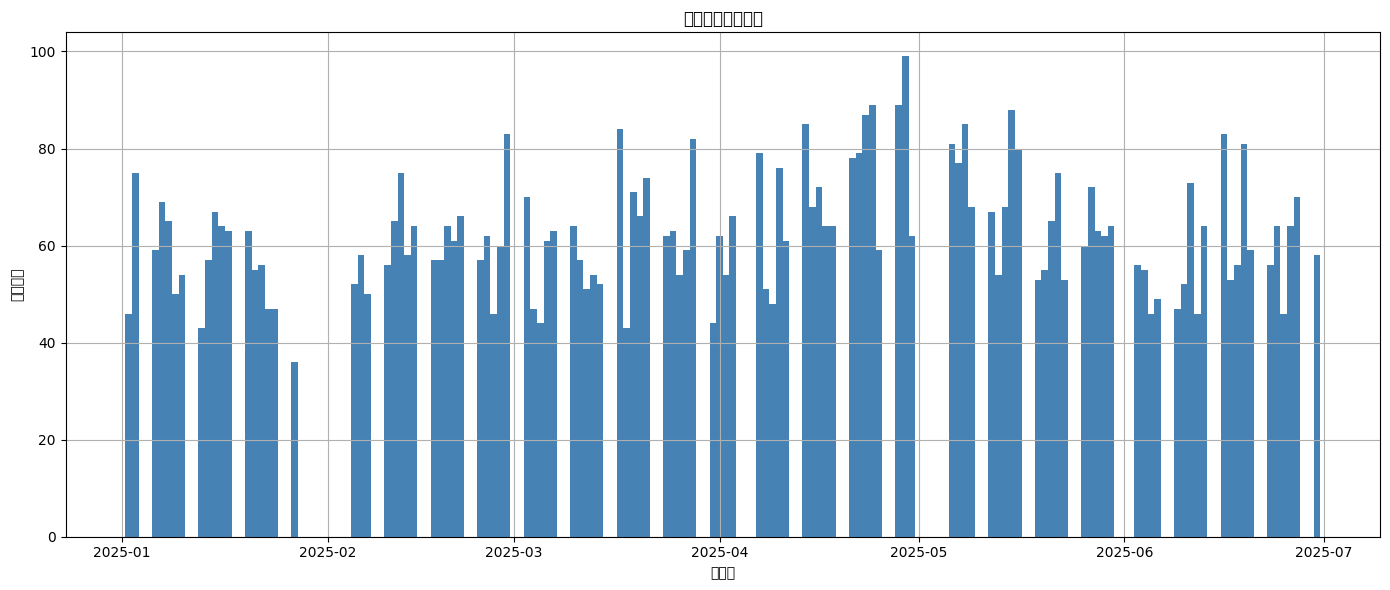

In [8]:
#看看每天交易量
# 仓位变动
merged['position_shift'] = merged['position'].shift(1)
merged['position_change'] = merged['position'] != merged['position_shift']

# 提取日期
df_trades = merged[merged['position_change']].copy()
df_trades['date'] = df_trades['DateTime'].dt.date

# 统计每天交易次数
daily_trade_counts = df_trades.groupby('date').size().reset_index(name='trade_count')

# 画个图
plt.figure(figsize=(14, 6))
plt.bar(daily_trade_counts['date'], daily_trade_counts['trade_count'], width=1.0, color='steelblue')
plt.title("每日交易次数分布")
plt.xlabel("交易日")
plt.ylabel("交易次数")
plt.grid(True)
plt.tight_layout()
plt.show()

写了第二份交易

In [ ]:
#两倍标准差开仓
merged['position'] = 0
for i in range(1, len(merged)):
    z_now = merged['zscore'].iloc[i]
    z_prev = merged['zscore'].iloc[i - 1]
    if z_now < -2:
        merged.loc[merged.index[i], 'position'] = 1
    elif z_now > 2:
        merged.loc[merged.index[i], 'position'] = -1
    elif z_prev * z_now < 0:
        merged.loc[merged.index[i], 'position'] = 0
    else:
        merged.loc[merged.index[i], 'position'] = merged['position'].iloc[i - 1]

#撮合交易
fee_rate = 0.0003 * 2
initial_cash = 1_000_000

merged['price_trade'] = np.nan
merged.loc[merged['position'] == 1, 'price_trade'] = merged['ETF_Sell1Price']
merged.loc[merged['position'] == -1, 'price_trade'] = merged['ETF_Buy1Price']

merged['price_shift'] = merged['price_trade'].shift(1)
merged['volume'] = initial_cash / merged['price_trade'].replace(0, np.nan)
merged['ret'] = (
    (merged['price_shift'] - merged['price_trade']) *
    merged['position'] * merged['volume'] -
    fee_rate * merged['ETF_Price'] * merged['volume']
)
merged['ret'] = merged['ret'].fillna(0)
merged['pnl'] = merged['ret'].cumsum()

#看看
plt.figure(figsize=(14, 5))
plt.plot(merged['DateTime'], merged['pnl'], label='IOPV trade2', color='blue')
plt.title("trade2")
plt.xlabel("time")
plt.ylabel("pnl")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#看看交易次数
merged['position_change'] = merged['position'].diff()
trade_open = merged['position_change'].abs() == 2
trade_time = merged.loc[trade_open, 'DateTime'].dt.date

# 统计
trade_counts = trade_time.value_counts().sort_index()

# 可视化
plt.figure(figsize=(14, 4))
plt.bar(trade_counts.index, trade_counts.values, color='teal')
plt.title("每日交易次数统计图")
plt.xlabel("交易日期")
plt.ylabel("交易次数")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#file_path = '518880.SH_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())


In [ ]:
#file_path = 'AU(T+D).SGE_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())

In [ ]:
#file_path = 'AU00.SHF_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())


In [ ]:
#file_path = 'AU99.99.SGE_20250101_20250630.parquet'

# 使用 pandas 读取
#df = pd.read_parquet(file_path)

# 显示前几行，检查是否读取成功
#print(df.head())
